In [31]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [32]:
import numpy as np 
import scipy.fft
from operators.mixed_method_0.mixed_method_0_operators import charge_density_two_stream_mixed_method_0
from operators.legendre.legendre_operators import xi_legendre
from operators.aw_hermite.aw_hermite_operators import aw_psi_hermite, aw_psi_hermite_complement
from operators.mixed_method_1.setup_mixed_method_1_two_stream import SimulationSetupMixedMethod1
from operators.poisson_solver import gmres_solver
from operators.reprojection_between_hermite_and_legendre import reprojection_aw_hermite_and_legendre
from operators.aw_hermite.aw_hermite_operators import total_mass_aw_hermite, total_momentum_aw_hermite, total_energy_k_aw_hermite
from operators.legendre.legendre_operators import total_mass_legendre, total_momentum_legendre, total_energy_k_legendre

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Enable LaTeX rendering
matplotlib.rcParams['text.usetex'] = True

In [34]:
# Get the 'inferno' colormap
inferno_cmap = plt.get_cmap('inferno')

# Sample the colormap at three different points (e.g., 25%, 50%, 75%)
color1 = inferno_cmap(0.)
color2 = inferno_cmap(0.4)
color3 = inferno_cmap(0.75)

# *Mixed method #1*: bump-on-tail instability 

In [1]:
setup = SimulationSetupMixedMethod1(Nx=101,
                                    Nv_e1=17,
                                    Nv_e2=int(2**6 - 17),
                                    epsilon=1e-4,
                                    v_a=4,
                                    v_b=15,
                                    L=20 * np.pi,
                                    dt=1e-2,
                                    T0=0,
                                    T=120,
                                    nu_L=1,
                                    nu_H=10,
                                    n0_e1=0.99,
                                    n0_e2=0.01,
                                    u_e1=0,
                                    u_e2=10,
                                    alpha_e1=np.sqrt(2),
                                    alpha_e2=np.sqrt(2),
                                    gamma=0.5,
                                    k0=0.1,
                                    Nv_int=5000,
                                    construct_integrals=False)

NameError: name 'SimulationSetupMixedMethod1' is not defined

In [36]:
if setup.construct_integrals:
    fig, ax = plt.subplots(figsize=(7, 3))
    ax.plot(np.arange(setup.Nv_e2), setup.J_int[-1, :], "-o", label="$\mathcal{J}_{N_{H}, m}$")
    ax.set_yscale("symlog", linthresh=1e-10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("$N_{H} = $" + str(setup.Nv_e1))
    ax.set_xlabel("$m$")
    legend = plt.legend()
    legend.get_frame().set_alpha(0)
    plt.tight_layout()

In [37]:
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx+1)
v_ = np.linspace(-5, 15, 15000, endpoint=True)

# simulation results

In [38]:
skip = 1
# load the simulation results
# save results
sol_midpoint_u = np.load("../../data/mixed_method_1_aw_hermite_legendre/bump_on_tail/sol_u_NvH_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_v_a_" + str(setup.v_a) + "_v_b_" + str(setup.v_b) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../../data/mixed_method_1_aw_hermite_legendre/bump_on_tail/sol_t_NvH_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_v_a_" + str(setup.v_a) + "_v_b_" + str(setup.v_b) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(12928, 12001)
(12001,)


In [39]:
runtime = np.load("../../data/mixed_method_1_aw_hermite_legendre/bump_on_tail/sol_runtime_NvH_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_v_a_" + str(setup.v_a) + "_v_b_" + str(setup.v_b) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([8245.829411  , 2177.77967119])

In [40]:
alpha_e1 = np.repeat(setup.alpha_e1[-1], len(sol_midpoint_t))
u_e1 = np.repeat(setup.u_e1[-1], len(sol_midpoint_t))


(0.0, 120.0)

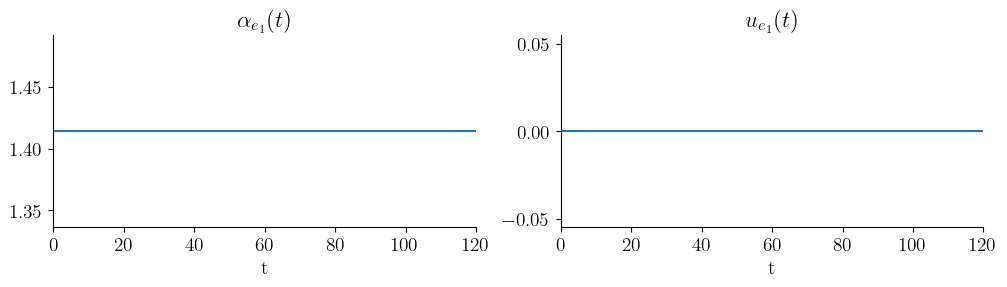

In [41]:
fig, ax  = plt.subplots(ncols=2, figsize=(12, 2.5))
ax[0].plot(sol_midpoint_t, alpha_e1)
ax[1].plot(sol_midpoint_t, u_e1)

ax[1].set_xlabel("t")
ax[0].set_xlabel("t")
ax[1].set_title(r"$u_{e_{1}}(t)$")
ax[0].set_title(r"$\alpha_{e_{1}}(t)$")

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_xlim(0, setup.T)
ax[1].set_xlim(0, setup.T)

In [42]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))
rho = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [43]:
# initialize the states for implicit midpoint (symplectic)
state_e_H = np.zeros((setup.Nv_e1,  setup.Nx + 1, len(sol_midpoint_t)))
state_e_L = np.zeros((setup.Nv_e2,  setup.Nx + 1, len(sol_midpoint_t)))

for ii in np.arange(0, len(sol_midpoint_t)):
    # immobile ions
    state_e_H[:, :-1, ii]  = np.reshape(sol_midpoint_u[:setup.Nv_e1*setup.Nx, ii], (setup.Nv_e1, setup.Nx)) 
    state_e_H[:, -1, ii] = state_e_H[:, 0, ii]
    # electrons species 2
    state_e_L[:, :-1, ii]  = np.reshape(sol_midpoint_u[setup.Nv_e1*setup.Nx:, ii], (setup.Nv_e2, setup.Nx))  
    state_e_L[:, -1, ii] = state_e_L[:, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho[:-1, ii] = charge_density_two_stream_mixed_method_0(q_e=setup.q_e, 
                                                   v_a=setup.v_a, v_b=setup.v_b, alpha_e=alpha_e1[ii],
                         C0_e_hermite=state_e_H[0, :setup.Nx, ii], 
                         C0_e_legendre=state_e_L[0, :setup.Nx, ii])
    

    E_midpoint[:-1, ii] = gmres_solver(rhs=rho[:-1, ii], D=setup.D, D_inv=setup.D_inv, a_tol=1e-12, r_tol=1e-12)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

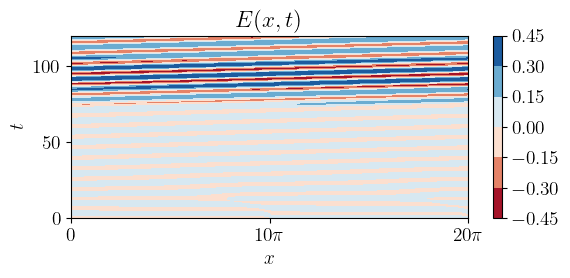

In [44]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu")
cbar = fig.colorbar(pos)
ax.set_title("$E(x, t)$")
ax.set_ylim(0, setup.T)
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, 10*np.pi, 20*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

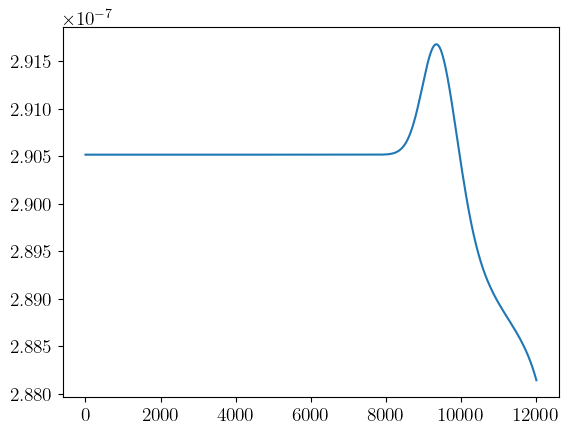

In [45]:
plt.plot(np.sum(rho, axis=0))

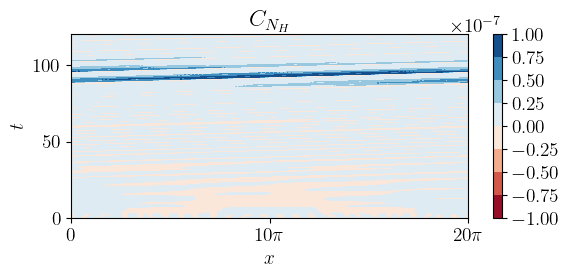

In [46]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(x, sol_midpoint_t, state_e_H[-1, :, :].T, cmap="RdBu")
cbar = fig.colorbar(pos)
ax.set_title("$C_{N_{H}}$")
ax.set_ylim(0, setup.T)
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, 10*np.pi, 20*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

In [47]:
# fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
# pos = ax[0].pcolormesh(x, sol_midpoint_t, (setup.v_b-setup.v_a) * state_e_L[0, :, :].T - np.load("hermite_beam_density.npy").T) 
# cbar = fig.colorbar(pos)
# pos = ax[1].pcolormesh(x, sol_midpoint_t, alpha_e1[-1] * state_e_H[0, :, :].T - np.load("hermite_bulk_density.npy").T ) 
# cbar = fig.colorbar(pos)
# plt.tight_layout()

(0.0, 120.0)

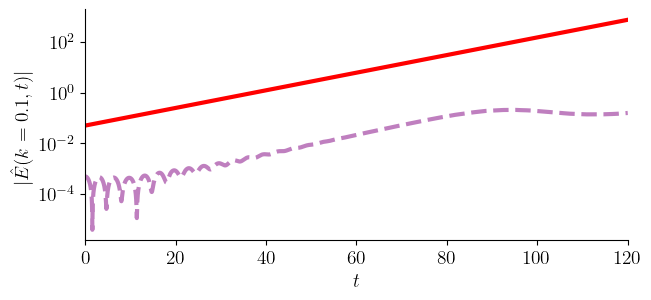

In [48]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, np.abs(np.fft.fft(E_midpoint, axis=0, norm="forward")[1, :]), "--", c="purple", alpha=0.5, linewidth=3, label="mixed method #1") 
ax.plot(sol_midpoint_t, 5e-2*np.exp(0.08*sol_midpoint_t), linewidth=3, color="red", label=r"theory $\gamma = 0.163993$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(k=0.1, t)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
#ax.set_ylim(1e-5, 1e-2)
# legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=14, loc='lower right')
# legend.get_frame().set_alpha(0)
#plt.tight_layout()
# plt.savefig("../../figures/mixed_method_1/bump_on_tail/bump_on_tail_growth_rate_legendre.png", dpi=300)

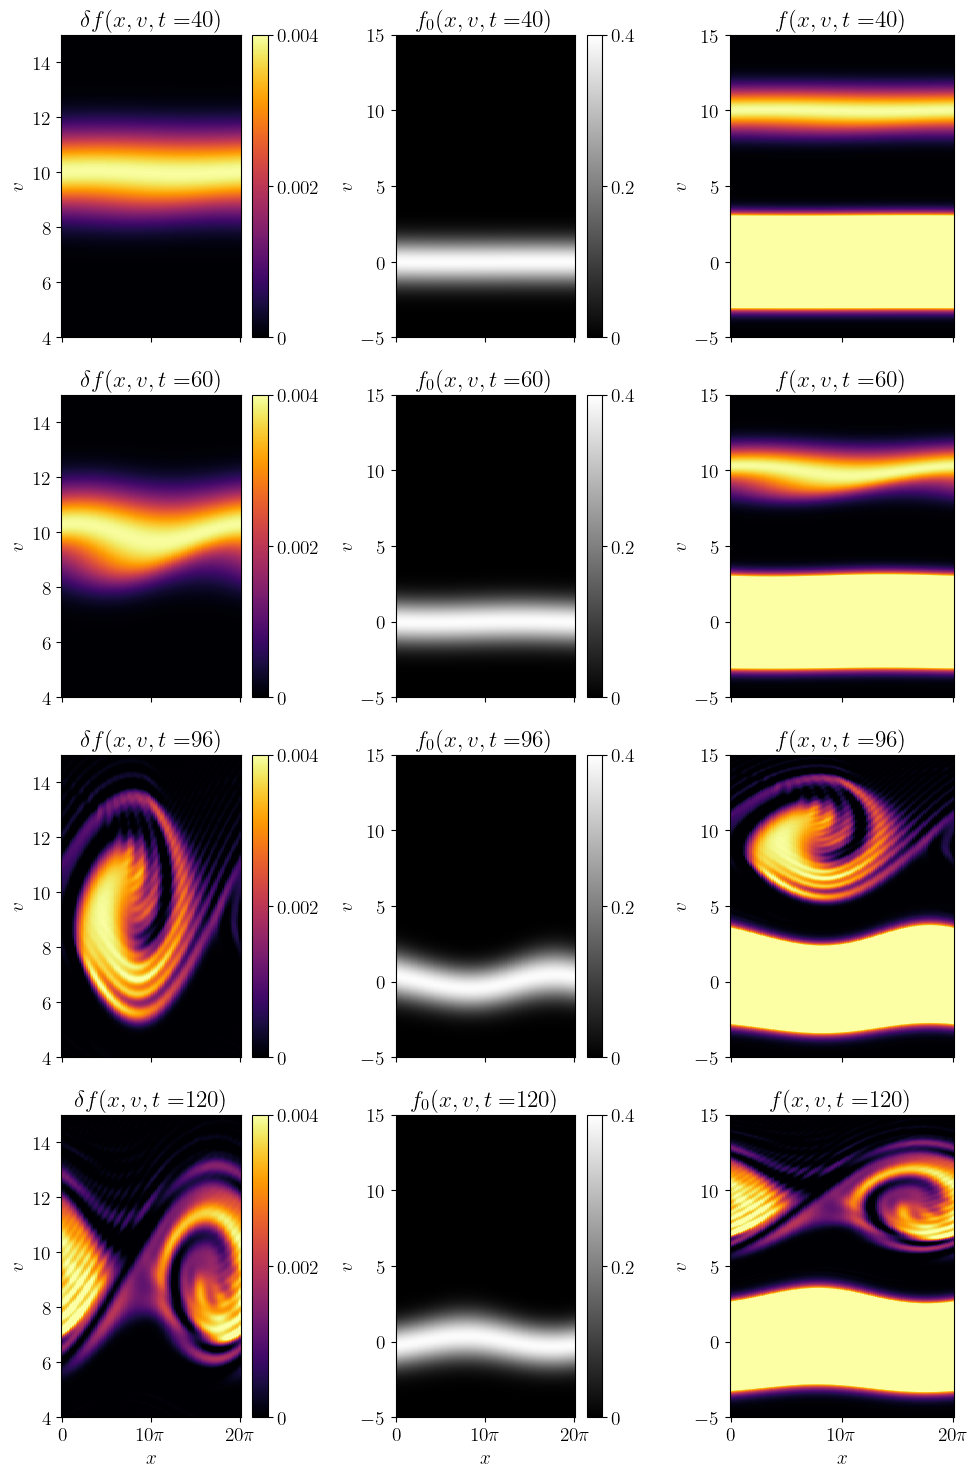

In [49]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10, 15), sharex=True)

levels = np.linspace(-0.05, 0.4, 50)

for tt, ii in enumerate([len(sol_midpoint_t)//3, len(sol_midpoint_t)//2, int(4*len(sol_midpoint_t)//5), int(-1)]):
    ii = int(ii)
    distribution1 = np.zeros((len(x), len(v_)))
    distribution2 = np.zeros((len(x), len(v_)))
    for jj in range(setup.Nv_e1):
        distribution1 += np.outer(state_e_H[jj, :, ii], aw_psi_hermite(v=v_, u_s=u_e1[ii], alpha_s=alpha_e1[ii], n=jj))
        
    for jj in range(setup.Nv_e2):
        for kk in range(len(v_)):
            if setup.v_a <= v_[kk] <= setup.v_b:
                distribution2[:, kk] += state_e_L[jj, :, ii] * xi_legendre(v=v_[kk], v_b=setup.v_b, v_a=setup.v_a, n=jj)
        
    pos2 = ax[tt, 0].pcolormesh(x, v_, distribution2.T, cmap="inferno", vmin=0, vmax=0.004)
    pos1 = ax[tt, 1].pcolormesh(x, v_, distribution1.T, cmap="gray", vmin=0, vmax=0.4)
    ax[tt, 2].pcolormesh(x, v_, distribution1.T + distribution2.T, cmap="inferno", vmin=0, vmax=0.004)
    
    ax[tt, 0].set_ylim(setup.v_a, setup.v_b)
    ax[tt, 1].set_ylim(-5, 15)
    ax[tt, 0].set_ylabel("$v$")
    ax[tt, 1].set_ylabel("$v$")
    ax[tt, 2].set_ylabel("$v$")
    cbar = fig.colorbar(pos1)
    cbar.set_ticks([0, 0.2, 0.4])
    cbar.set_ticklabels(["0", "0.2", "0.4"])
    
    ax[tt, 1].set_title('$f_{0}(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")")
    cbar = fig.colorbar(pos2)
    cbar.set_ticks([0, 0.002, 0.004])
    cbar.set_ticklabels(["0", "0.002", "0.004"])
    ax[tt, 0].set_title('$\delta f(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")")
    ax[tt, 2].set_title('$f(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")")

    
ax[tt, 0].set_xlabel("$x$")
ax[tt, 0].set_xticks([0, 10*np.pi, 20*np.pi])
ax[tt, 0].set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
ax[tt, 2].set_xlabel("$x$")
ax[tt, 1].set_xlabel("$x$")
ax[tt, 1].set_xticks([0, 10*np.pi, 20*np.pi])
ax[tt, 1].set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])

plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/bump_on_tail/bump_on_tail_evolution_mixed_method_1_nuL_" + str(setup.nu_L) + "_nuH_" + str(setup.nu_H) + "_Nv_L_" + str(setup.Nv_e2) + "_Nv_H_" + str(setup.Nv_e1) +  "_adapt.png", dpi=600)

In [50]:
np.save("../../data/mixed_method_1_aw_hermite_legendre/bump_on_tail/E_field_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_v_a_" +  str(setup.v_a) + "_v_b_" + str(setup.v_b) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy", E_midpoint)

In [51]:
np.save("../../data/mixed_method_1_aw_hermite_legendre/bump_on_tail/distribution_t_120_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_v_a_" +  str(setup.v_a) + "_v_b_" + str(setup.v_b) +  "_" + str(setup.T0) + "_" + str(setup.T) + ".npy", distribution1 + distribution2)

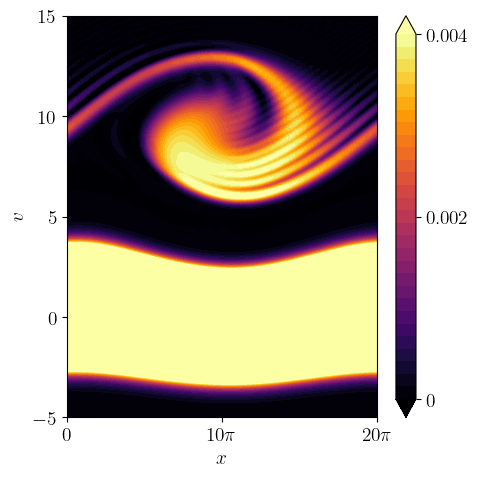

In [52]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(figsize=(5, 5), sharex=True)

ii = np.argmin(np.abs(sol_midpoint_t - 90))
distribution1 = np.zeros((len(x), len(v_)))
distribution2 = np.zeros((len(x), len(v_)))

for jj in range(setup.Nv_e1):
    distribution1 += np.outer(state_e_H[jj, :, ii], aw_psi_hermite(v=v_, u_s=u_e1[ii], alpha_s=alpha_e1[ii], n=jj))
    
for jj in range(setup.Nv_e2):
    for kk in range(len(v_)):
        if setup.v_a <= v_[kk] <= setup.v_b:
            distribution2[:, kk] += state_e_L[jj, :, ii] * xi_legendre(v=v_[kk], v_b=setup.v_b, v_a=setup.v_a, n=jj)
    
pos = ax.contourf(x, v_, distribution1.T + distribution2.T, cmap="inferno", vmin=0, vmax=0.004, levels=np.linspace(0, 0.004, 30), extend="both")

ax.set_ylim(-5, 15)
ax.set_ylabel("$v$")
ax.set_xlabel("$x$")
cbar = fig.colorbar(pos)
cbar.set_ticks([0, 0.002, 0.004])
cbar.set_ticklabels(["0", "0.002", "0.004"])
ax.set_yticks([-5, 0, 5, 10, 15])
ax.set_xticks([0, 10*np.pi, 20*np.pi])
ax.set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/bump_on_tail/bump_on_tail_phase_space_mm_t_90_Nv_" + str(setup.Nv_e1 + setup.Nv_e2) + ".png", dpi=300)

# conservation laws: mass, momentum, and energy

### mass conservation

In [53]:
# compute mass at each timestamp
mass_midpoint_H = np.zeros(len(sol_midpoint_t))
mass_midpoint_L = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint_H[ii] = total_mass_aw_hermite(state=state_e_H[:, :-1, ii], alpha_s=alpha_e1[ii], dx=setup.dx)
    mass_midpoint_L[ii] = total_mass_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx)

mass_midpoint = mass_midpoint_L + mass_midpoint_H

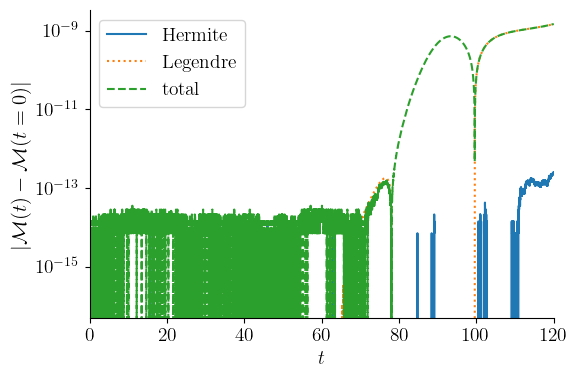

In [54]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, mass_midpoint_H - mass_midpoint_H[0], "-", label="Hermite")
ax.plot(sol_midpoint_t, mass_midpoint_L - mass_midpoint_L[0], ":", label="Legendre")
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "--", label="total")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{M}(t) - \mathcal{M}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.legend()
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()

### momentum conservation

In [55]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum_aw_hermite(state=state_e_H[:, :-1, ii], alpha_s=alpha_e1[ii], u_s=u_e1[ii],
                                                   dx=setup.dx, m_s=setup.m_e)\
                            +total_momentum_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)

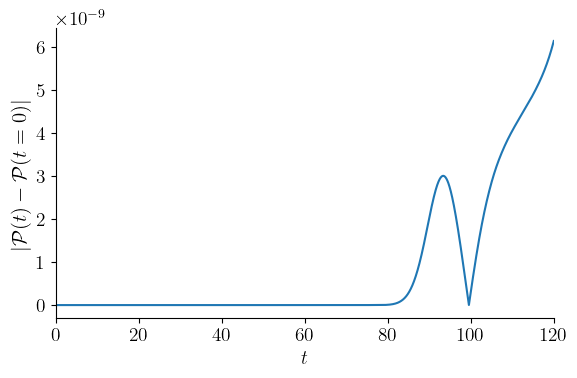

In [56]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{P}(t)-\mathcal{P}(t=0)|$", fontsize=15)
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$t$")
plt.tight_layout()

### energy conservation

In [57]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k_aw_hermite(state=state_e_H[:, :-1, ii], alpha_s=alpha_e1[ii],
                                                   u_s=u_e1[ii], dx=setup.dx, m_s=setup.m_e)\
                           +total_energy_k_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

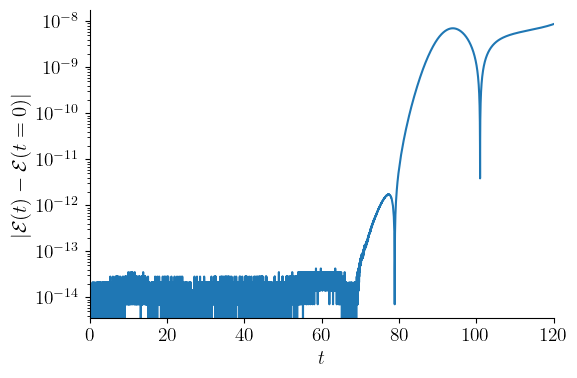

In [58]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{E}(t)-\mathcal{E}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

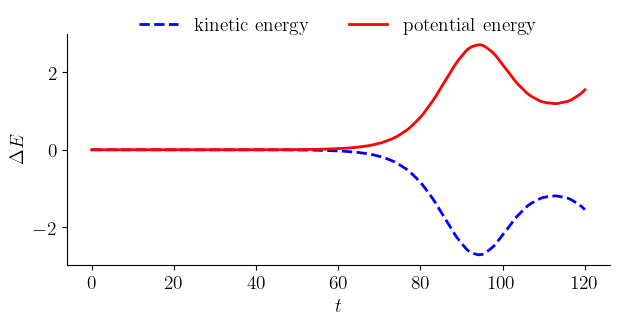

In [59]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("$t$")
_ = ax.set_ylabel(r"$\Delta E$")

### conservation summary

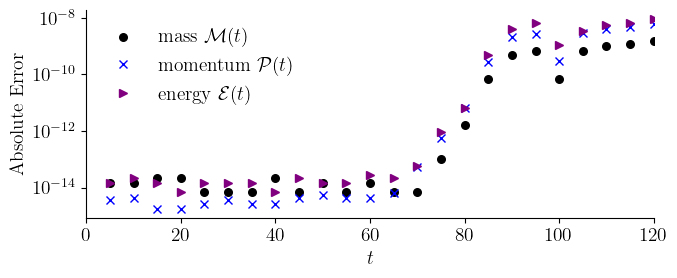

In [60]:
# plot the analytic and numerical conservation properties
skip = 500

fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::skip], np.abs(mass_midpoint-mass_midpoint[0])[::skip], s=30, color="black", label=r"mass $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(momentum_midpoint-momentum_midpoint[0])[::skip], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::skip], ">", color="purple", label=r"energy $\mathcal{E}(t)$")

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
legend = ax.legend(ncols=1, fontsize=14, loc='upper left')
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.tight_layout()